In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
import optuna
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

In [34]:
try:
    df = pd.read_csv('archive/creditcard.csv')
    print(f"Dataset loaded. Shape: {df.shape}")
    print("Class Distribution:")

    print(df['Class'].value_counts(normalize=True))
except FileNotFoundError:
    print("Error: The file 'creditcard.csv' was not found.")


Dataset loaded. Shape: (284807, 31)
Class Distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [35]:
duplicates = df.duplicated()
print(len(df[duplicates]))
df[duplicates].head(10)

1081


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
221,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,...,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0
223,145.0,-2.419486,1.949346,0.552998,0.982710,-0.284815,2.411200,-1.398537,-0.188922,0.675695,...,1.213390,-1.238354,0.007191,-1.724175,0.239721,-0.313607,-0.187431,0.119472,6.74,0
1178,919.0,0.904289,-0.538055,0.396058,0.500680,-0.864473,-0.657199,0.027231,-0.029473,0.265447,...,-0.099460,-0.597579,-0.048666,0.551824,0.182934,0.402176,-0.081357,0.027252,158.00,0
1180,919.0,1.207596,-0.036860,0.572104,0.373148,-0.709633,-0.713698,-0.181105,0.011277,0.283940,...,-0.194591,-0.514717,0.089714,0.543768,0.240581,0.418921,-0.051693,-0.000085,1.00,0
1382,1074.0,-2.248488,-0.195670,0.026949,-0.525780,-0.238759,-0.033359,0.162196,0.928520,-0.424215,...,-0.032208,-0.745757,-0.243193,-0.821633,-0.030402,0.335838,-0.286998,-0.243768,158.00,0


In [36]:
df = df.drop_duplicates()
duplicates = df.duplicated()
print(len(df[duplicates]))

0


In [7]:
display(df.describe())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


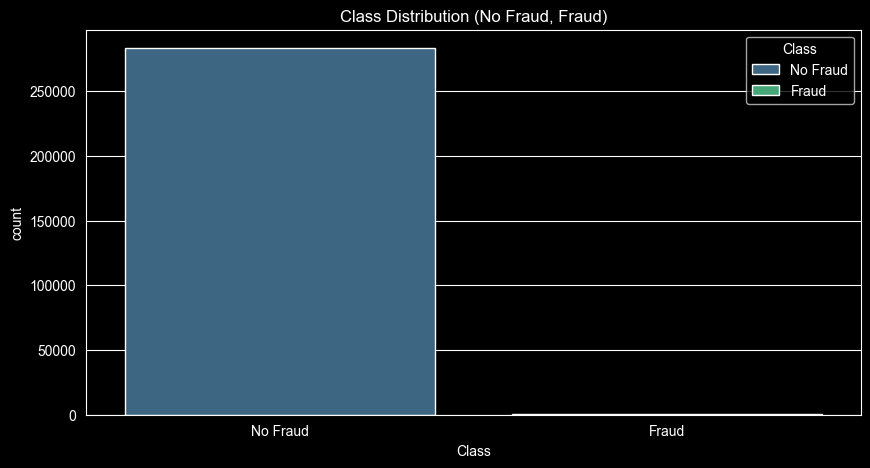

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(x='Class', data=df, ax=ax, hue='Class', palette='viridis')
ax.set_title('Class Distribution (No Fraud, Fraud)')
ax.set_xticks([0, 1])
ax.set_xticklabels(['No Fraud', 'Fraud'])

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, ['No Fraud', 'Fraud'], title='Class')

In [9]:
df_agg = df.copy()
df_agg['hour'] = df_agg['Time'] // 3600
df_agg = df_agg.groupby('hour')['Amount'].sum().reset_index()

df_agg.head(3)

,hour,Amount
0,0.0,256354.95
1,1.0,146043.52
2,2.0,108813.17


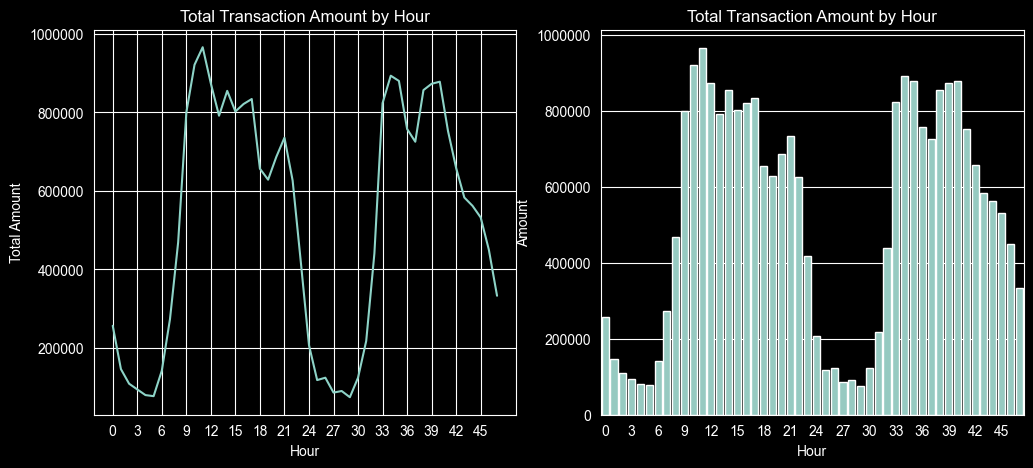

In [10]:
ticks = range(0, int(df_agg['hour'].max()) + 1, 3)
fig, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].plot(df_agg['hour'], df_agg['Amount'])
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Total Amount')
ax[0].set_title('Total Transaction Amount by Hour')
ax[0].set_xticks(np.arange(0, df_agg['hour'].max()+1, 3,dtype = int))
ax[0].ticklabel_format(style='plain', axis='y')

sns.barplot(data=df_agg,x='hour',y = 'Amount', ax=ax[1])
ax[1].set_xticks(ticks)
ax[1].set_xticklabels([int(t) for t in ticks])
ax[1].set_xlabel('Hour')
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title('Total Transaction Amount by Hour')
plt.show()

In [ ]:
#ok as i see that i don't have missing values at all, so i will not calculate the percentage or doing something more, that's enough here
total = df.isnull().sum().sort_values(ascending=False)
total

In [37]:
#we have already scalled p1-p28 because we used pca, so we need to scale other columns like amount and time, scaling is super important feature when u working with NN, for trees it's not such important, but here some values already scalled, the only reason we will be using it here
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

X = df.drop('Class', axis=1)
Y = df['Class']

#i thing it's obvious why we use stratify split as data so unbalanced here
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [50]:
print(f"Froud before SMOTE: {sum(Y_train)} (Classes are unbalanced)")
print(f"Not Froud : {len(Y_train) - sum(Y_train)} (Classes are unbalanced)")
sm = SMOTE(random_state=42)
X_train_bal, Y_train_bal = sm.fit_resample(X_train, Y_train)

print(f"Updated Froud after SMOTE: {sum(Y_train_bal)} (Classes are now balanced)")
X_train_bal.shape

Froud before SMOTE: 378 (Classes are unbalanced)
Not Froud : 226602 (Classes are unbalanced)
Updated Froud after SMOTE: 226602 (Classes are now balanced)


(453204, 30)

In [ ]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
    }

    model = RandomForestClassifier(
        **params,
        random_state=42,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_val_score(
        model,
        X_train,
        Y_train,
        cv=cv,
        scoring="average_precision",
        n_jobs=-1
    )

    return scores.mean()

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


In [ ]:
best_rf = RandomForestClassifier(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, Y_train)

In [ ]:
y_pred = best_rf.predict(X_test)
confusion_matrix(X_test, y_pred)